In [11]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time

# データベースの準備
def setup_database():
    conn = sqlite3.connect("jalan_hotels.db")
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS hotels (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            rank INTEGER,
            name TEXT,
            price TEXT,
            rating REAL
        )
    ''')
    conn.commit()
    return conn, cursor

# スクレイピング関数
def scrape_jalan():
    url = "https://www.jalan.net/ranking/ryokan/index.html"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    response.encoding = response.apparent_encoding

    if response.status_code != 200:
        print("Failed to fetch the webpage. Status code:", response.status_code)
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    print("Page fetched successfully. Analyzing content...")

    hotels = []
    # 宿情報を持つ要素を取得
    hotel_list = soup.find_all("div", class_="jlnpc-ranking__casette__textArea")
    if not hotel_list:
        print("No hotel data found. Check the page structure.")
        print(response.text[:1000])  # デバッグ用にHTMLの一部を出力
        return []

    for hotel in hotel_list:
        try:
            # 順位
            rank_tag = hotel.find("span", class_="jlnpc-ranking__casette__rank")
            rank = int(rank_tag["class"][-1][-2:]) if rank_tag else None  # `rank--01`から順位を取得

            # 宿名
            name_tag = hotel.find("h4", class_="jlnpc-ranking__casette__title").find("a")
            name = name_tag.text.strip() if name_tag else None

            # 最安料金
            price_tag = hotel.find("p", class_="jlnpc-ranking__casette__headPrice")
            price = price_tag.strong.text.strip() if price_tag else None

            # 評価
            rating_tag = hotel.find("p", class_="jlnpc-ranking__casette__score")
            rating = float(rating_tag.text.strip()) if rating_tag else None

            if rank and name and price and rating:
                hotels.append((rank, name, price, rating))
        except (AttributeError, ValueError) as e:
            print(f"Error parsing hotel data: {e}")
            continue

    return hotels

# データをデータベースに挿入
def insert_data(cursor, hotels):
    cursor.executemany(
        """
        INSERT INTO hotels (rank, name, price, rating)
        VALUES (?, ?, ?, ?)
        """,
        hotels
    )

# メイン処理
def main():
    conn, cursor = setup_database()
    hotels = scrape_jalan()

    if hotels:
        insert_data(cursor, hotels)
        conn.commit()
        print(f"{len(hotels)}件の宿情報をデータベースに保存しました。")
    else:
        print("宿情報の取得に失敗しました。")

    conn.close()

if __name__ == "__main__":
    main()


Page fetched successfully. Analyzing content...
20件の宿情報をデータベースに保存しました。


Correlation matrix:
            rank     price    rating
rank    1.000000  0.254221  0.143170
price   0.254221  1.000000  0.361313
rating  0.143170  0.361313  1.000000


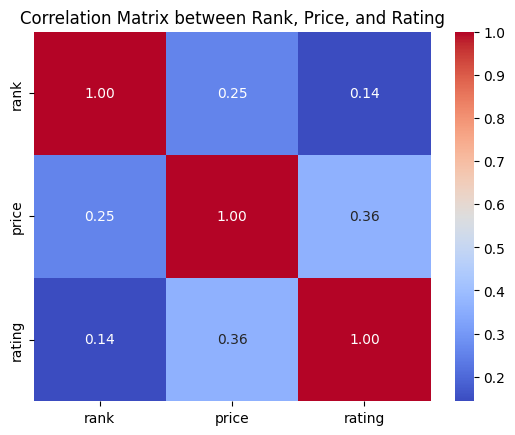

In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# SQLiteデータベースからデータを取得
conn = sqlite3.connect("jalan_hotels.db")
query = "SELECT rank, price, rating FROM hotels"
df = pd.read_sql(query, conn)
conn.close()

# 価格データのクリーニング
df['price'] = df['price'].replace({r'円～': '', r'円': '', r',': ''}, regex=True).astype(float)

# 相関関係の計算
correlation_matrix = df.corr()

# 相関行列を表示
print("Correlation matrix:")
print(correlation_matrix)

# 相関関係を視覚化する
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between Rank, Price, and Rating")
plt.show()
